In [ ]:
# import

import sys
import os

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from model import cnn_model
from loss import FocalLoss
from train import train_one_epoch
from utils import NpArrayDataset
from utils import reduce_datasets
from eval import predict_one_epoch


In [3]:
# import (local)

%load_ext autoreload
%autoreload 2

In [ ]:
X_train = np.loadtxt("data/input.csv", delimiter=',')
Y_train = np.loadtxt("data/labels.csv", delimiter=',')

X_test = np.loadtxt("data/input_test.csv", delimiter=',')
Y_test = np.loadtxt("data/labels_test.csv", delimiter=',')

print("X_train shape : ", X_train.data.shape)
print("Y_train shape : ", Y_train.data.shape)
print("X_test shape : ", X_test.data.shape)
print("Y_test shape : ", Y_test.data.shape)

X_train shape :  (2000, 30000)
Y_train shape :  (2000,)
X_test shape :  (400, 30000)
Y_test shape :  (400,)


In [127]:
X_train = X_train.reshape(len(X_train), 100, 100, 3)
Y_train = Y_train.reshape(len(Y_train), 1)

X_test = X_test.reshape(len(X_test), 100, 100, 3)
Y_test = Y_test.reshape(len(Y_test), 1)

print("X_train shape : ", X_train.data.shape)
print("Y_train shape : ", Y_train.data.shape)
print("X_test shape : ", X_test.data.shape)
print("Y_test shape : ", Y_test.data.shape)

X_train shape :  (2000, 100, 100, 3)
Y_train shape :  (2000, 1)
X_test shape :  (400, 100, 100, 3)
Y_test shape :  (400, 1)


In [128]:
#  normalisation

X_train = X_train / 255.0
X_test = X_test / 255.0

[0.]


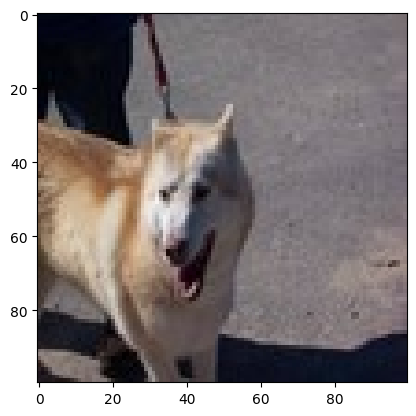

In [ ]:
import random

classes = {
    0: 'chien',
    1: 'chat',
}

idx = random.randint(0, len(X_train))
plt.imshow(X_train[idx,:])
print(Y_train[idx])

/tmp/ipykernel_221617/2588873046.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=noms_labels, palette=['#3498db', '#e67e22'])


Text(0, 0.5, 'nbres images')

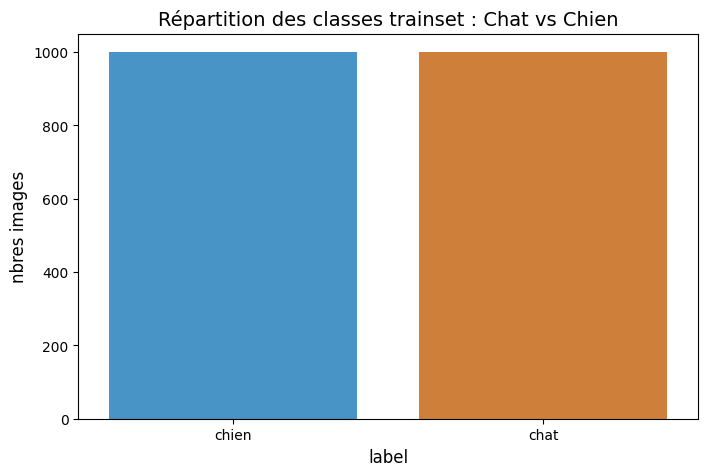

In [ ]:
classes = {
    0: 'chien',
    1: 'chat',
}

noms_labels = [classes[l] for l in Y_train.flatten()]

plt.figure(figsize=(8, 5))

ax = sns.countplot(x=noms_labels, palette=['#3498db', '#e67e22'])

plt.title('Répartition des classes trainset : Chat vs Chien', fontsize=14)
plt.xlabel('label', fontsize=12)
plt.ylabel('nbres images', fontsize=12)

In [ ]:
image_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

target_transforms = None

In [ ]:
# load the training data
train_set = NpArrayDataset(
    images=X_train,
    labels=Y_train,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)

test_set = NpArrayDataset(
    images=X_test,
    labels=Y_test,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

test_loader = DataLoader(train_set, batch_size=16, shuffle=True)

2000


In [ ]:
# Init the training
model = cnn_model()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

print(DEVICE)
model = model.to(DEVICE)

train_losses = []
valid_losses = []

EPOCHS = 20
# loop over the dataset multiple times
for epoch in range(EPOCHS):
    model.train()
    train_epoch_loss = train_one_epoch(model, criterion, optimizer, train_loader, DEVICE)
    # model.eval()
    # valid_epoch_loss = valid_one_epoch(model, val_loader)

    print(f"EPOCH={epoch}, TRAIN={train_epoch_loss:.05f}")

    train_losses.append(train_epoch_loss)
    # valid_losses.append(valid_epoch_loss)

cpu


100%|██████████| 125/125 [00:08<00:00, 14.39it/s]


EPOCH=0, TRAIN=0.70501


100%|██████████| 125/125 [00:07<00:00, 17.00it/s]


EPOCH=1, TRAIN=0.66955


100%|██████████| 125/125 [00:07<00:00, 16.91it/s]


EPOCH=2, TRAIN=0.61820


100%|██████████| 125/125 [00:04<00:00, 25.69it/s]


EPOCH=3, TRAIN=0.62121


100%|██████████| 125/125 [00:07<00:00, 16.68it/s]


EPOCH=4, TRAIN=0.54878


100%|██████████| 125/125 [00:07<00:00, 17.16it/s]


EPOCH=5, TRAIN=0.49203


100%|██████████| 125/125 [00:07<00:00, 16.79it/s]


EPOCH=6, TRAIN=0.41856


100%|██████████| 125/125 [00:07<00:00, 16.63it/s]


EPOCH=7, TRAIN=0.35552


100%|██████████| 125/125 [00:04<00:00, 26.92it/s]


EPOCH=8, TRAIN=0.27394


100%|██████████| 125/125 [00:07<00:00, 17.12it/s]

EPOCH=9, TRAIN=0.22622


In [ ]:
y_true, y_pred = predict_one_epoch(model, test_loader, DEVICE)

100%|██████████| 125/125 [00:00<00:00, 286.18it/s]


Accuracy : 0.9770
F1-Score : 0.9771
Confusion matrix


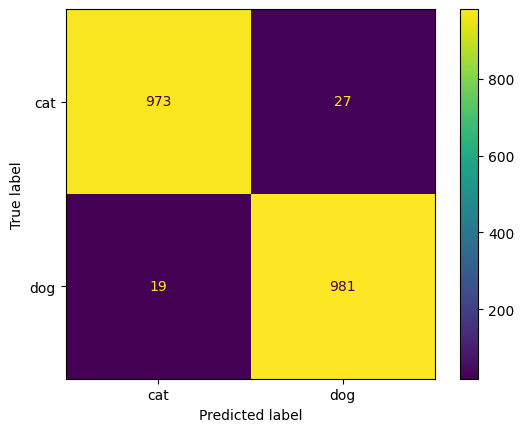

In [ ]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"F1-Score : {f1:.4f}")

print("Confusion matrix")
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["cat", "dog"])

disp.plot()
plt.show()


In [ ]:
# modifies the dataset

ratio = 0.1
X_train_unbalanced, Y_train_unbalanced = reduce_datasets(X_train, Y_train, ratio=ratio)
X_test_unbalanced, Y_test_unbalanced = reduce_datasets(X_test, Y_test, ratio=ratio)

/tmp/ipykernel_221617/2875148828.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=noms_labels, palette=['#3498db', '#e67e22'])


Text(0, 0.5, 'nbres images')

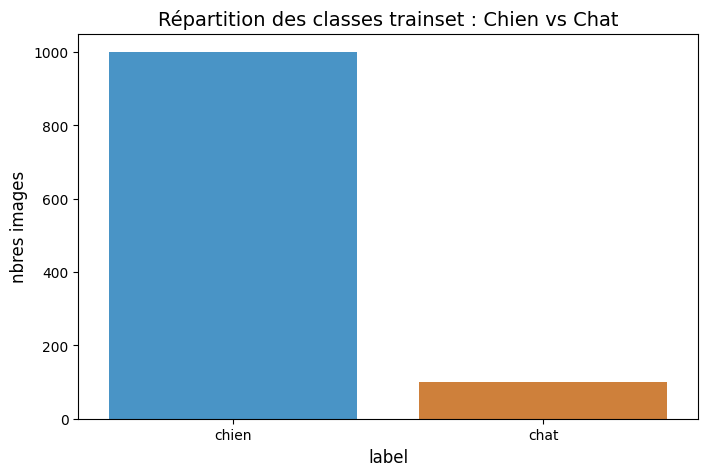

In [ ]:
classes = {
    0: 'chien',
    1: 'chat',
}

noms_labels = [classes[l] for l in Y_train_unbalanced.flatten()]

plt.figure(figsize=(8, 5))

ax = sns.countplot(x=noms_labels, palette=['#3498db', '#e67e22'])

plt.title('Répartition des classes trainset : Chien vs Chat', fontsize=14)
plt.xlabel('label', fontsize=12)
plt.ylabel('nbres images', fontsize=12)

In [139]:
# load the training data

train_set = NpArrayDataset(
    images=X_train_unbalanced,
    labels=Y_train_unbalanced,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)

test_set = NpArrayDataset(
    images=X_test_unbalanced,
    labels=Y_test_unbalanced,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

In [140]:
# Init the training
model = cnn_model()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)
model = model.to(DEVICE)

train_losses = []
valid_losses = []

EPOCHS = 10
# loop over the dataset multiple times
for epoch in range(EPOCHS):
    model.train()
    train_epoch_loss = train_one_epoch(model, criterion, optimizer, train_loader, DEVICE)
    # model.eval()
    # valid_epoch_loss = valid_one_epoch(model, val_loader)

    print(f"EPOCH={epoch}, TRAIN={train_epoch_loss:.05f}")

    train_losses.append(train_epoch_loss)
    # valid_losses.append(valid_epoch_loss)

cpu


100%|██████████| 69/69 [00:02<00:00, 27.31it/s]


EPOCH=0, TRAIN=0.34709


100%|██████████| 69/69 [00:02<00:00, 26.83it/s]


EPOCH=1, TRAIN=0.31230


100%|██████████| 69/69 [00:02<00:00, 27.11it/s]


EPOCH=2, TRAIN=0.28735


100%|██████████| 69/69 [00:02<00:00, 26.80it/s]


EPOCH=3, TRAIN=0.25482


100%|██████████| 69/69 [00:02<00:00, 27.81it/s]


EPOCH=4, TRAIN=0.23010


100%|██████████| 69/69 [00:02<00:00, 27.50it/s]


EPOCH=5, TRAIN=0.18506


100%|██████████| 69/69 [00:00<00:00, -31848.46it/s]


EPOCH=6, TRAIN=0.12614


100%|██████████| 69/69 [00:02<00:00, 27.00it/s]


EPOCH=7, TRAIN=0.08835


100%|██████████| 69/69 [00:02<00:00, 26.19it/s]


EPOCH=8, TRAIN=0.09820


100%|██████████| 69/69 [00:02<00:00, 26.71it/s]

EPOCH=9, TRAIN=0.06881


In [ ]:
# predire le dataset de test

y_true, y_pred = predict_one_epoch(model, test_loader, DEVICE)

100%|██████████| 14/14 [00:00<00:00, 75.00it/s]


Accuracy : 0.8682
F1-Score : 0.2162
Confusion matrix


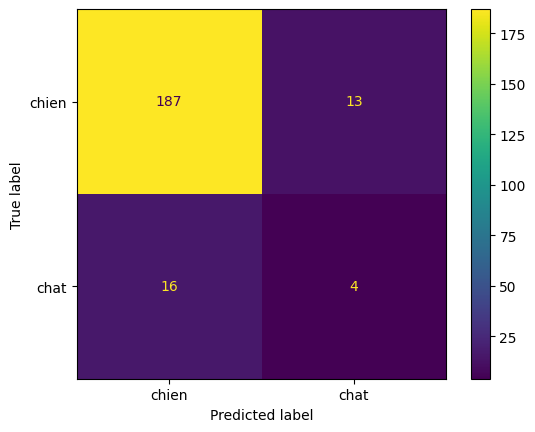

In [ ]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"F1-Score : {f1:.4f}")

print("Confusion matrix")
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["chien", "chat"])

disp.plot()
plt.show()


In [ ]:
# Init the training
del model
model = cnn_model()

criterion = FocalLoss(gamma=2, alpha=0.80, task_type='binary')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

print(DEVICE)
model = model.to(DEVICE)

train_losses = []
valid_losses = []

EPOCHS = 20
# loop over the dataset multiple times
for epoch in range(EPOCHS):
    model.train()
    train_epoch_loss = train_one_epoch(model, criterion, optimizer, train_loader, DEVICE)
    # model.eval()
    # valid_epoch_loss = valid_one_epoch(model, val_loader)

    print(f"EPOCH={epoch+1}, TRAIN={train_epoch_loss:.05f}")

    train_losses.append(train_epoch_loss)
    # valid_losses.append(valid_epoch_loss)

cpu


  0%|          | 0/69 [00:00<?, ?it/s]

100%|██████████| 69/69 [00:02<00:00, 25.41it/s]


EPOCH=0, TRAIN=0.04422


100%|██████████| 69/69 [00:00<00:00, 470.29it/s]


EPOCH=1, TRAIN=0.03671


100%|██████████| 69/69 [00:02<00:00, 24.72it/s]


EPOCH=2, TRAIN=0.03441


100%|██████████| 69/69 [00:02<00:00, 25.49it/s]


EPOCH=3, TRAIN=0.03413


100%|██████████| 69/69 [00:02<00:00, 24.74it/s]


EPOCH=4, TRAIN=0.03121


100%|██████████| 69/69 [00:02<00:00, 24.75it/s]


EPOCH=5, TRAIN=0.02769


100%|██████████| 69/69 [00:02<00:00, 25.71it/s]


EPOCH=6, TRAIN=0.02346


100%|██████████| 69/69 [00:02<00:00, 24.89it/s]


EPOCH=7, TRAIN=0.02107


100%|██████████| 69/69 [00:02<00:00, 25.69it/s]


EPOCH=8, TRAIN=0.02060


100%|██████████| 69/69 [00:02<00:00, 26.53it/s]


EPOCH=9, TRAIN=0.01577


100%|██████████| 69/69 [00:02<00:00, 25.13it/s]


EPOCH=10, TRAIN=0.01059


100%|██████████| 69/69 [00:02<00:00, 25.47it/s]


EPOCH=11, TRAIN=0.00833


100%|██████████| 69/69 [00:02<00:00, 25.06it/s]


EPOCH=12, TRAIN=0.00392


100%|██████████| 69/69 [00:00<00:00, 393.94it/s]


EPOCH=13, TRAIN=0.00341


100%|██████████| 69/69 [00:02<00:00, 26.63it/s]


EPOCH=14, TRAIN=0.00142


100%|██████████| 69/69 [00:02<00:00, 25.24it/s]


EPOCH=15, TRAIN=0.00114


100%|██████████| 69/69 [00:02<00:00, 25.13it/s]


EPOCH=16, TRAIN=0.00148


100%|██████████| 69/69 [00:02<00:00, 27.40it/s]


EPOCH=17, TRAIN=0.00086


100%|██████████| 69/69 [00:02<00:00, 26.91it/s]


EPOCH=18, TRAIN=0.00070


100%|██████████| 69/69 [00:02<00:00, 25.22it/s]

EPOCH=19, TRAIN=0.00045


In [ ]:
y_true, y_pred = predict_one_epoch(model, test_loader, DEVICE)

100%|██████████| 69/69 [00:00<00:00, 71.60it/s]


Accuracy : 1.0000
F1-Score : 1.0000
Confusion matrix


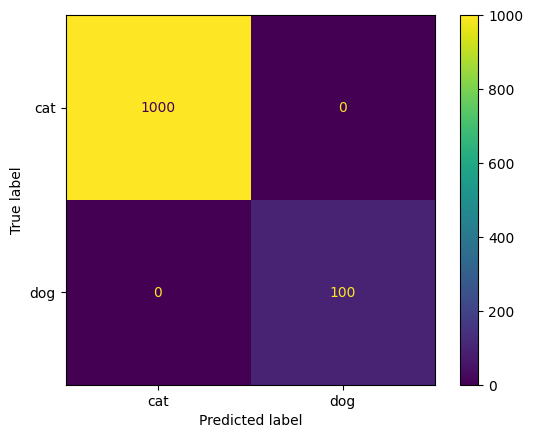

In [ ]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"F1-Score : {f1:.4f}")

print("Confusion matrix")
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["cat", "dog"])

disp.plot()
plt.show()